In [9]:
import os
import sys

sys.path.append(f'../../')
sys.path.append(f'analytic')


from tools import LTEpop, profile, lineEmissivity, lineOpacity, lineSource, I_CMB


import numpy             as np
import magritte.setup    as setup
import magritte.core     as magritte


dimension = 1
npoints   = 50
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 1

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
rho_in = 2.0E13   # [m^-3]
temp   = 2.0E+01                 # [K]
turb   = 0#1.5E+02                 # [m/s]
X_mol  = 1.0E-8   # [.]

def rho (r):
    return rho_in * np.power(r_in/r, 2.0)

def abn (r):
    return X_mol * rho(r)

rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)

modelFile = 'all_constant_1D.hdf5'
lamdaFile = '../data/test.txt'

model = magritte.Model ()

model.parameters.set_spherical_symmetry(False)
model.parameters.set_model_name(modelFile)
model.parameters.set_dimension (dimension)
model.parameters.set_npoints   (npoints)
model.parameters.set_nrays     (nrays)
model.parameters.set_nspecs    (nspecs)
model.parameters.set_nlspecs   (nlspecs)
model.parameters.set_nquads    (nquads)

model.geometry.points.position.set([[r, 0, 0] for r in rs])
model.geometry.points.velocity.set([[0, 0, 0] for i in range(npoints)])

model.chemistry.species.abundance = [[     0.0, abn(r), rho(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()
model.read ()

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()
# model.compute_radiation_field         ()
model.compute_radiation_field_2nd_order_Feautrier()


x  = np.array(model.geometry.points.position)[:,0]
nu = np.array(model.radiation.frequencies.nu)
u  = np.array(model.radiation.u)


ld = model.lines.lineProducingSpecies[0].linedata

k = 0

frq = ld.frequency[k]
pop = LTEpop         (ld, temp)
phi = profile        (ld, k, temp, (turb/magritte.CC)**2, frq)
eta = lineEmissivity (ld, pop)[k] * phi
chi = lineOpacity    (ld, pop)[k] * phi
src = lineSource     (ld, pop)[k]
bdy = I_CMB          (frq)


def I_0 (x):
    return src + (bdy-src)*np.exp(-chi*X_mol*rho_in*r_in*(1.0    - r_in/x    ))

def I_1 (x):
    return src + (bdy-src)*np.exp(-chi*X_mol*rho_in*r_in*(r_in/x - r_in/r_out))

def u_01 (x):
    return 0.5 * (I_0(x) + I_1(x))

def relative_error (a,b):
    return 2.0*(a-b)/(a+b)


error = relative_error (u_01(x), u[0,:,0])

print('max error in u =', np.max(np.abs(error)))

['cmb', 'cmb']
max error in u = 0.169170704013398693


In [10]:
import matplotlib.pyplot as plt

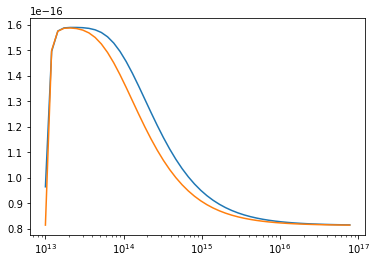

In [11]:
plt.plot(x, u[0,:,0])
plt.plot(x, u_01(x) )
plt.xscale('log')